In [216]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


In [217]:

def vander(x,k):
    res = np.ones((len(x),k))
    for i in range(1,k):
        res[:,i] = x**i
    return res


def split_data(X, Y, Ntrain):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain, Xtest, Ytest)


def dataset_normal(N,k,treshold=0.7,a=0, b=1, variance=0.1,plot= False):
    theta_true = np.ones((k,))
    X = np.linspace(a,b,N)
    phi = vander(X,k)
    Y = phi@theta_true
    train = round(N*0.7)
    noise = np.random.normal(0,variance,len(Y))
    Xtrain,Ytrain,Xtest,Ytest = split_data(X,Y+noise,train)
    D = (Xtrain,Ytrain)
    T = (Xtest,Ytest)
    if(plot == True):
        plt.figure(figsize=(3,3))
        plt.plot(X,Y+noise,"ro",markersize=3)
        plt.grid()
        plt.show()
    return D, T, theta_true


def abs_error(D,K,theta):
    X,Y = D
    N = len(X)
    phi = vander(X,K)
    return np.linalg.norm(phi@theta - Y,2)**2 / N


def err(theta, true):
    t = len(true)
    l = len(theta)
    pad_true = np.pad(true,(0,l-t),'constant',constant_values=(0))
    return np.linalg.norm(theta - pad_true,2) / np.linalg.norm(pad_true,2)


def plot_approximation(D, K, theta, a=0, b=1, points=1000, all=False, T=(), lam=[], type="normal"):
    
    Xtrain,Ytrain = D
    plt.plot(Xtrain,Ytrain,"ro", markersize=3)
    if(all == True):
        Xtest,Ytest = T
        plt.plot(Xtest,Ytest,"bo", markersize=3)
        if(len(lam) > 0):
            for l in lam:
                theta_map = map(D, K, l, type="normal")
                XX = np.linspace(a,b,points)
                YY = vander(XX,K) @ theta_map
                plt.plot(XX, YY)
            plt.legend(["Train set","Test set"]+lam)
        else:
            XX = np.linspace(a,b,points)
            YY = vander(XX,K) @ theta
            plt.plot(XX, YY)
    else:
        XX = np.linspace(a,b,points)
        YY = vander(XX,K) @ theta
        plt.plot(XX, YY)
    plt.grid()
    plt.show()





In [218]:
def ell(theta, K, X, Y):
    return 0.5 * (np.linalg.norm(vander(X, K)@theta - Y)**2)

def grad_ell(theta, K, X, Y):
    return vander(X, K).T @ (((vander(X, K))@theta) - Y)

def ell_map(lam):
    return lambda theta, K, X, Y: 0.5 * ((np.linalg.norm(vander(X, K)@theta - Y)**2) + (lam/2) * np.linalg.norm(theta)**2)

def grad_ell_map(lam):
    return lambda theta, K, X, Y: vander(X, K).T @ ((vander(X, K) @ theta) - Y) + 2 * lam * theta

In [219]:
def GD(t0, D, K, tolf=1e-6, tolx=1e-6, kmax=1000, alpha=1e-2, f=ell, grad_f=grad_ell):
    (X, Y) = D

    tk = t0
    f_vals = [f(tk, K, X, Y)]
    grad_vals = [grad_f(tk, K, X, Y)]
    err_vals = [np.linalg.norm(grad_f(tk, K, X, Y))]
    t_vals = [tk]
    iteration = 0

    while iteration < kmax:
        t_prec = tk

        tk = t_prec - (alpha*grad_f(t_prec, K, X, Y))

        t_vals.append(tk)
        f_vals.append(f(tk, K, X, Y))
        grad_vals.append(grad_f(tk, K, X, Y))       
        err_vals.append(np.linalg.norm(grad_f(tk, K, X, Y)))

        iteration+=1

        if np.linalg.norm(grad_f(tk, K, X, Y)) < tolf:
            break

        if np.linalg.norm(tk - t_prec, 2) < tolx:
            break

    return tk

def SGD(t0, D, K, batch_size = 5, n_epochs = 10, alpha=1e-5, l=ell, grad_l=grad_ell):
    (X, Y) = D
    N = len(X)
    
    X_backup = X
    Y_backup = Y


    n_batch_per_epoch = N // batch_size
    t_vals = [t0]
    f_vals = [l(t0, K, X, Y)]
    grad_f_vals = [grad_l(t0, K, X, Y)]
    err_vals = [np.linalg.norm(grad_l(t0, K, X, Y))]

    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)

        for k in range(n_batch_per_epoch):
            batch_indices = idx[k * batch_size : (k + 1) * batch_size]

            Mx = X[batch_indices]
            My = Y[batch_indices]

            t = t_vals[-1] - alpha * grad_l(t_vals[-1], K, Mx, My)
            t_vals.append(t)

        
        X = X_backup
        Y = Y_backup
        f_vals.append(l(t, K, X, Y))
        grad_f_vals.append(grad_l(t, K, X, Y))
        err_vals.append(np.linalg.norm(grad_l(t, K, X, Y)))

    return t_vals[-1]


In [256]:
def mle(D, K, type="normal", var=0.1):
    (X,Y) = D
    phi = vander(X,K)
    theta = np.ones(K)
    
    match type:
        case "normal":
            theta_mle = np.linalg.solve(phi.T @ phi, phi.T @ Y)
            #L = np.linalg.cholesky(phi.T @ phi)
            #y = sp.linalg.solve_triangular(L, phi.T @ Y, lower=True)
            
            #y = np.linalg.solve(L,phi.T @ Y)
            #theta_mle = sp.linalg.solve_triangular(L.T,y)
            return theta_mle
        case "GD":
            theta_zero = np.zeros((K,))
            theta = GD(theta_zero, D, K)
            return theta
        case "SGD":
            theta_zero = np.random.normal(1, var, K) 
            theta = SGD(theta_zero, D, K)
            return theta
        case _:
            print("Type not recognized")
            return theta



In [258]:
def map(D, K, lam=0.5 , type="normal",var=0.1):
    (X,Y) = D
    phi = vander(X,K)
    theta = np.ones(K)

    match type:
        case "normal":
            theta_map = np.linalg.solve(phi.T @ phi + np.identity(K)*lam, phi.T @ Y)
            #L = np.linalg.cholesky(phi.T @ phi + np.identity(K)*lam)
            #y = np.linalg.solve(L,phi.T @ Y)
            #theta_map = sp.linalg.solve_triangular(L.T,y)
            return theta_map
        case "GD":
            theta_zero = np.zeros((K,))
            theta = GD(theta_zero, D, K, f=ell_map(lam), grad_f=grad_ell_map(lam))
            return theta
        case "SGD":
            theta_zero = np.random.normal(1, var, K)
            theta = SGD(theta_zero, D, K, l=ell_map(lam), grad_l = grad_ell_map(lam))
            return theta
        case _:
            print("Type not recognized")
            return theta

Initialization

In [252]:
N = 100
K = 4
D,T, theta_true = dataset_normal(N,K,variance=0.5,plot=False)

Xtrain, Ytrain = D
Xtest, Ytest = T


MLE Normal EQ

Absolute error on training set:  0.16396971196903634
Absolute error on test set:  0.2625885295717488
Err(theta):  4449365.815271784


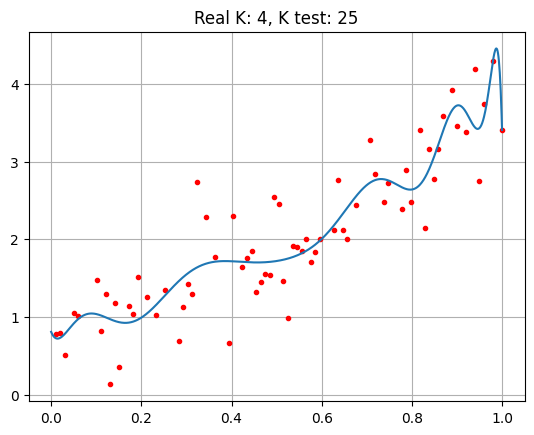

Absolute error on training set:  0.19349604594443218
Absolute error on test set:  0.25270431192891646
Err(theta):  1.74934042177158


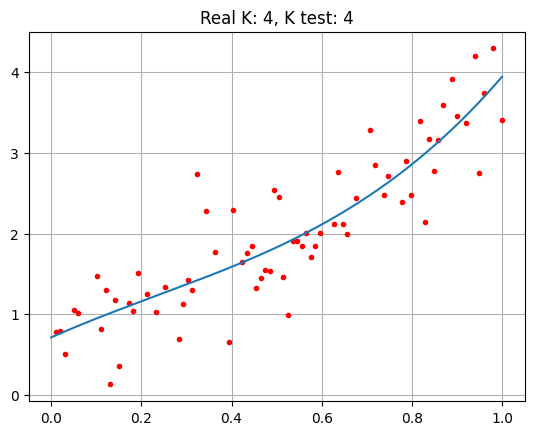

Absolute error on training set:  0.21859338000927564
Absolute error on test set:  0.2968425129267996


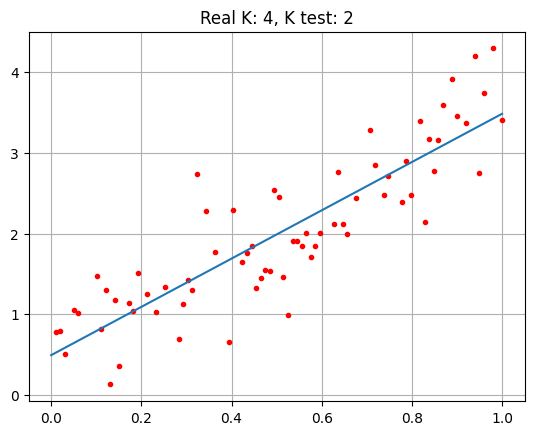

In [257]:
K_test = 25

theta_mle = mle(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)


K_test = 4

theta_mle = mle(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)

K_test = 2

theta_mle = mle(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)



The best tradeoff is given by K = 3


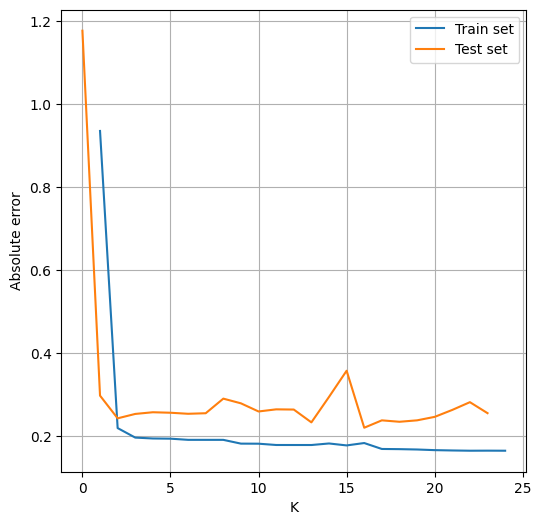

In [262]:
train_errors = []
test_errors = []
maxK = 25
for k in range(1,maxK):
    theta_mle = mle(D,k, type="normal")
    train_errors.append(abs_error(D,k,theta_mle))
    test_errors.append(abs_error(T,k,theta_mle))
    

dif = abs(np.array(train_errors) - np.array(test_errors))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)
x_plot = np.arange(1,maxK)
#print(train_errors)
plt.figure(figsize=(6,6))
plt.plot(x_plot,train_errors, test_errors)
plt.legend(["Train set", "Test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.grid()
plt.show()

MLE(GD)

Absolute error on training set:  0.15032362270458927
Absolute error on test set:  0.1762477095187669
Err(theta):  0.6373788942867621


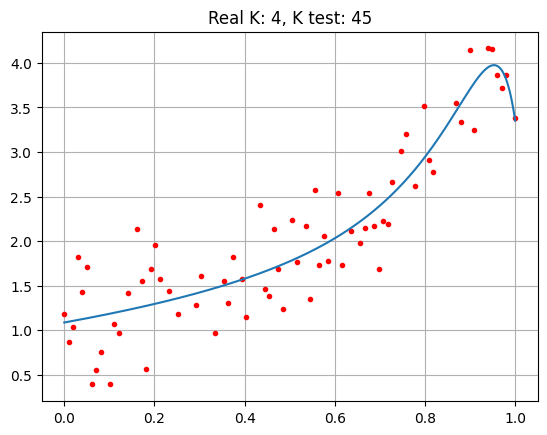

Absolute error on training set:  0.1658187420720048
Absolute error on test set:  0.13037496562903306
Err(theta):  0.3787767773841479


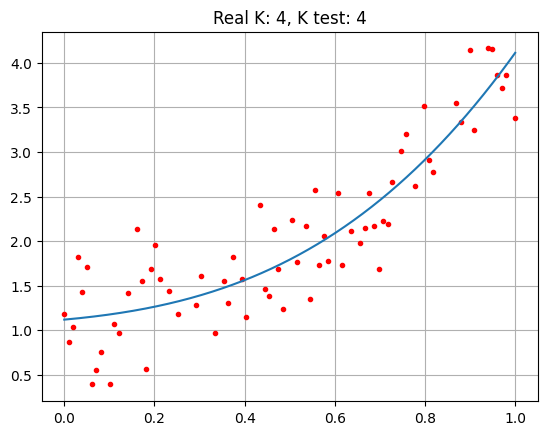

In [226]:
K_test = 45

theta_mle = mle(D, K_test, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)


K_test = 4

theta_mle = mle(D, K_test, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)

MLE SGD

Absolute error on training set:  20.576034454497545
Absolute error on test set:  18.318138076197037
Err(theta):  2.309551215045965


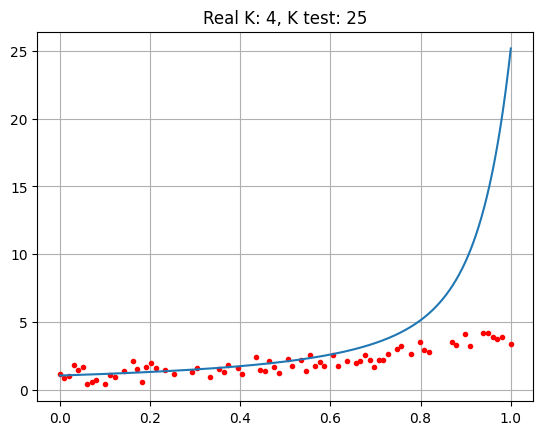

Absolute error on training set:  0.19328193899984822
Absolute error on test set:  0.1791756933754747
Err(theta):  0.07271236263610081


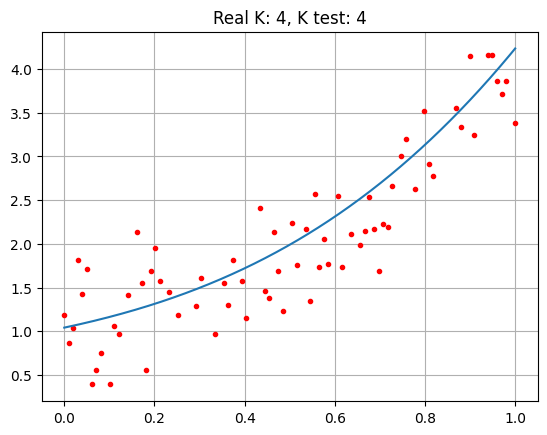

In [227]:
K_test = 25

theta_mle = mle(D, K_test, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)


K_test = 4

theta_mle = mle(D, K_test, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)

MAP (NORMAL EQ)

Absolute error on training set:  0.1901775986959094
Absolute error on test set:  0.25438364207632314
Err(theta):  119.62681690738128


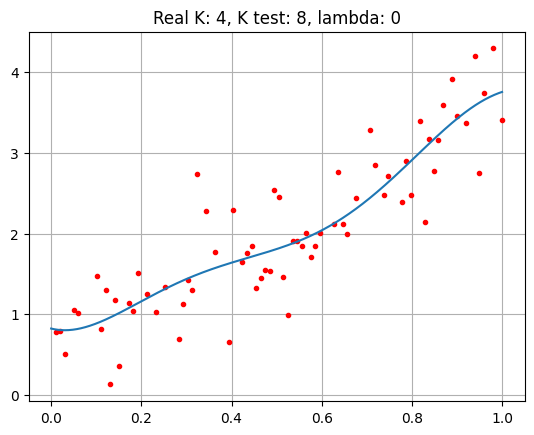

Absolute error on training set:  0.19551961498131498
Absolute error on test set:  0.24459365561619603
Err(theta):  0.36406976863217927


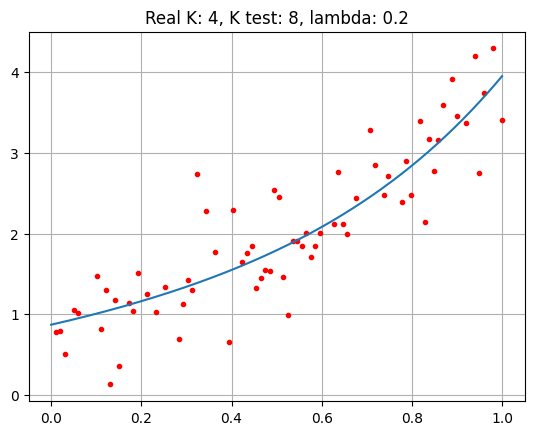

Absolute error on training set:  0.19352734623942536
Absolute error on test set:  0.2476430577742809
Err(theta):  0.4243421619161197


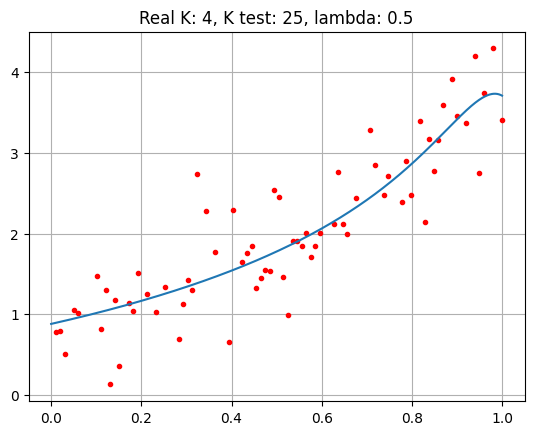

In [259]:

K_test = 8
lam = 0

theta_map = map(D, K_test,lam, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test)+", lambda: "+str(lam))
plot_approximation(D, K_test, theta_map)

lam = 0.2
K_test = 8

theta_map = map(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test)+", lambda: "+str(lam))
plot_approximation(D, K_test, theta_map)

lam = 0.5
K_test = 25

theta_map = map(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test)+", lambda: "+str(lam))
plot_approximation(D, K_test, theta_map)


The best tradeoff is given by K = 5


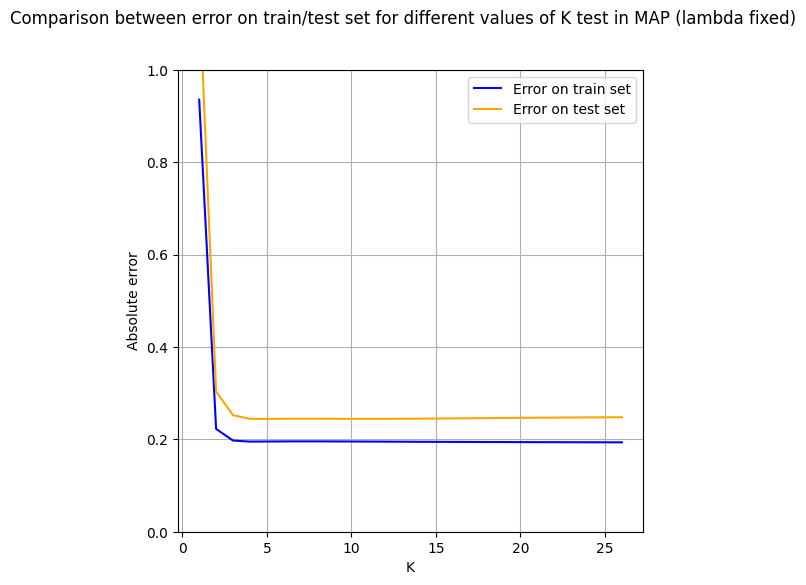

In [260]:
train_errors = []
test_errors = []
maxk = 27
for k in range(1, maxk):
    theta_map = map(D, k, type="normal")
    train_errors.append(abs_error(D,k,theta_map))
    test_errors.append(abs_error(T,k,theta_map))

dif = abs(np.array(train_errors) - np.array(test_errors))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)

x_plot = np.arange(1,maxk)
plt.figure(figsize=(6,6))
plt.suptitle("Comparison between error on train/test set for different values of K test in MAP (lambda fixed)")
plt.plot(x_plot, train_errors, color="blue")
plt.plot(x_plot, test_errors, color="orange")
plt.legend(["Error on train set","Error on test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.ylim(0,1)
plt.grid()
plt.show()


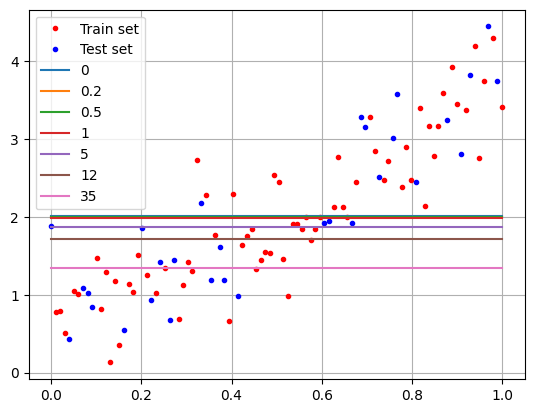

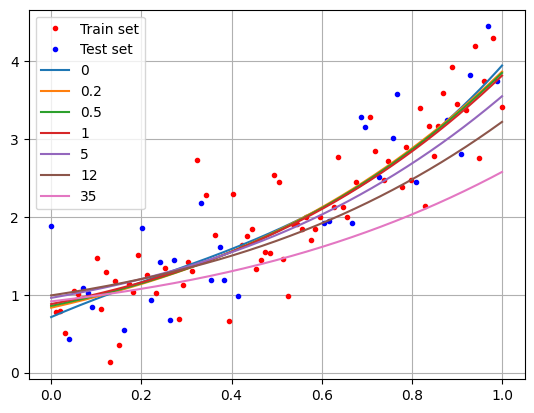

LinAlgError: Matrix is not positive definite

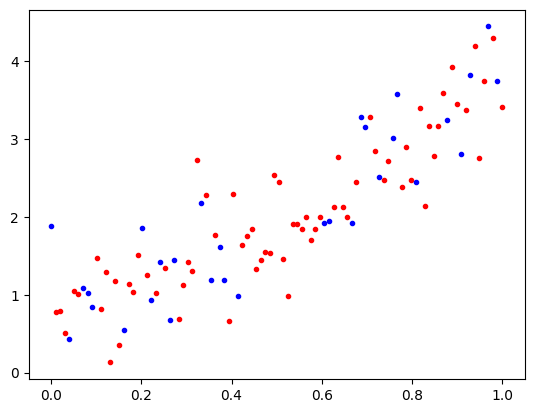

In [261]:
lam_values = [0, 0.2, 0.5, 1, 5, 12, 35]

K_test = 1
theta_map = map(D, K_test,lam, type="normal")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 4
theta_map = map(D, K_test, type="normal")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 15
theta_map = map(D, K_test, type="normal")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

MAP WITH GD

Absolute error on training set:  0.1642682198054155
Absolute error on test set:  0.13190878990031632
Err(theta):  0.5939683664093778


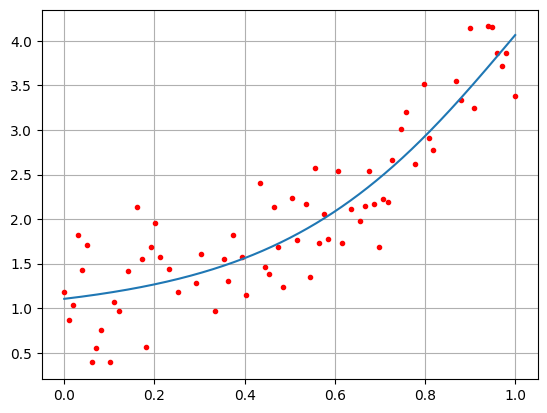

Absolute error on training set:  0.16826729958778402
Absolute error on test set:  0.13413745048004408
Err(theta):  0.3945193989146365


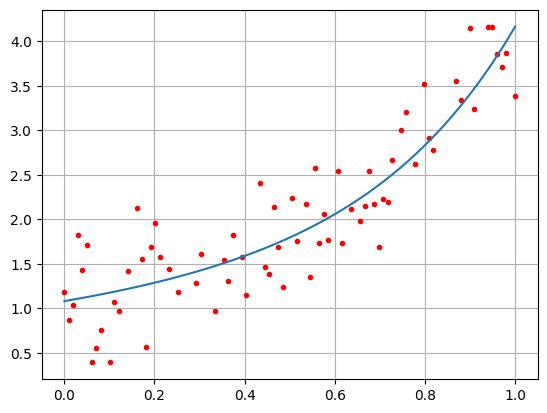

Absolute error on training set:  0.15447004855780366
Absolute error on test set:  0.14961281259036507
Err(theta):  0.539129462877696


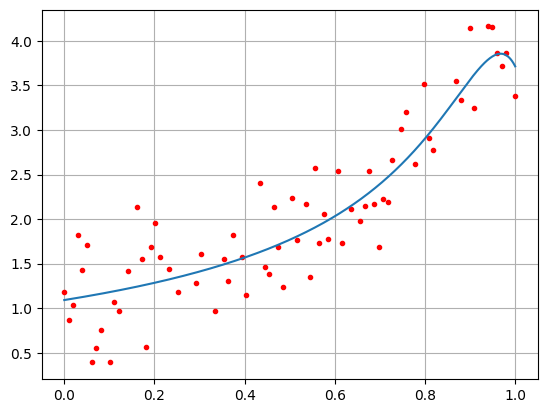

In [232]:

K_test = 8
lam = 0

theta_map = map(D, K_test,lam, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

lam = 0.2
K_test = 8

theta_map = map(D, K_test, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

lam = 0.5
K_test = 25

theta_map = map(D, K_test, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

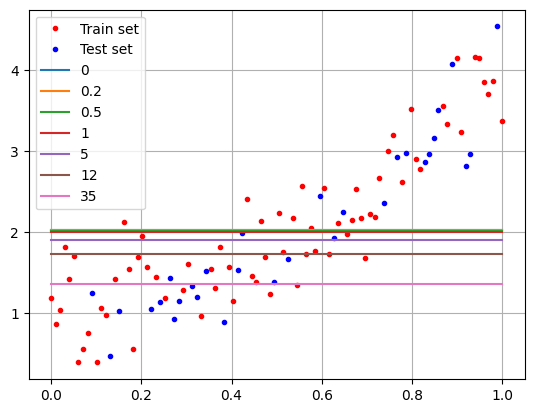

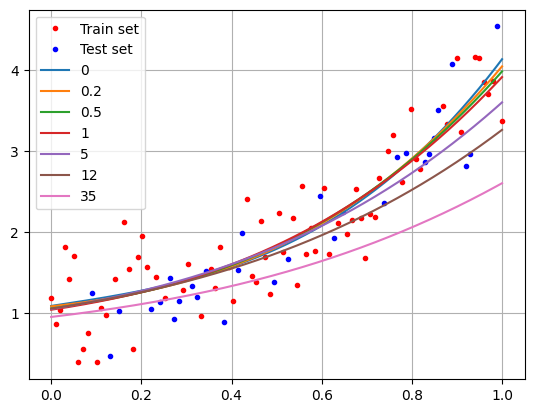

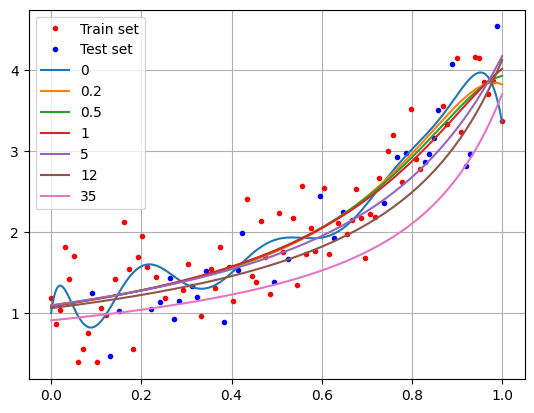

In [233]:
lam_values = [0, 0.2, 0.5, 1, 5, 12, 35]

K_test = 1
theta_map = map(D, K_test,lam, type="GD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 4
theta_map = map(D, K_test, type="GD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 15
theta_map = map(D, K_test, type="GD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

MAP SGD

Absolute error on training set:  1.409472404680161
Absolute error on test set:  1.525287988454998
Err(theta):  1.0392117292652234


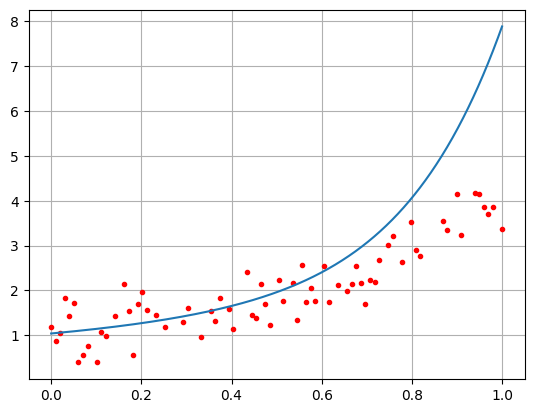

Absolute error on training set:  1.3228565372593415
Absolute error on test set:  1.4347445849087472
Err(theta):  0.9407610011519645


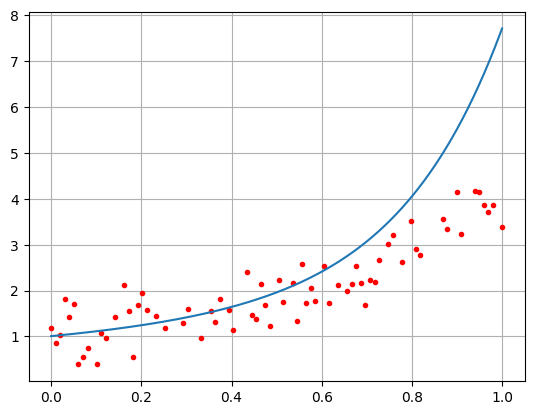

Absolute error on training set:  19.67112421883598
Absolute error on test set:  17.390288981067897
Err(theta):  2.2927119589634644


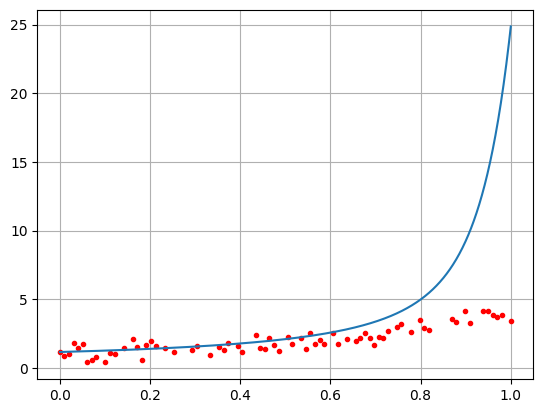

In [234]:
K_test = 8
lam = 0

theta_map = map(D, K_test,lam, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

lam = 0.2
K_test = 8

theta_map = map(D, K_test, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

lam = 0.5
K_test = 25

theta_map = map(D, K_test, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

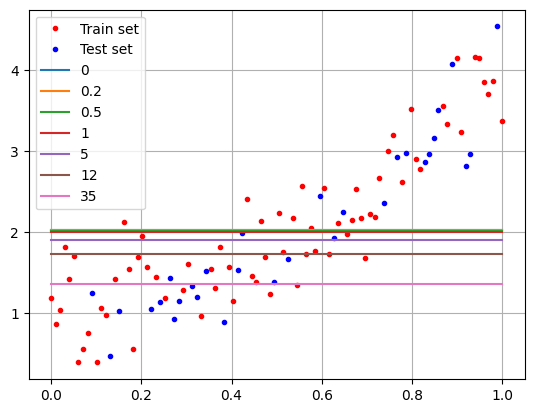

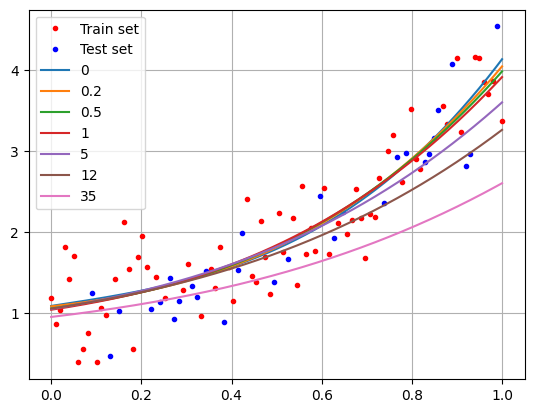

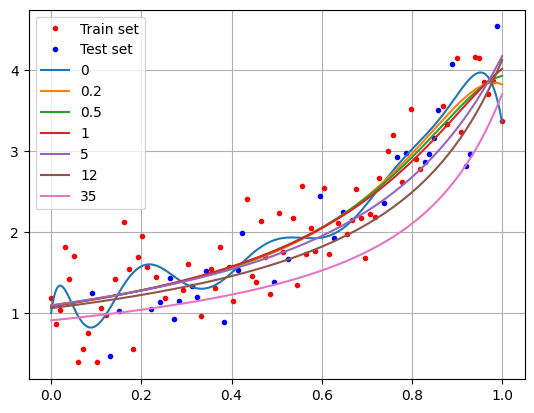

In [235]:
lam_values = [0, 0.2, 0.5, 1, 5, 12, 35]

K_test = 1
theta_map = map(D, K_test,lam, type="SGD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 4
theta_map = map(D, K_test, type="SGD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 15
theta_map = map(D, K_test, type="SGD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

DIFFERENT VALUES OF N

In [236]:
N2 = 1000
K2 = 4
D2, T2, theta_true2 = dataset_normal(N2,K2, variance=0.5,plot=False)

Xtrain, Ytrain = D2
Xtest, Ytest = T2

Absolute error on training set:  0.2355730251483019
Absolute error on test set:  0.26986396063402884
Err(theta):  3839933.9318510555


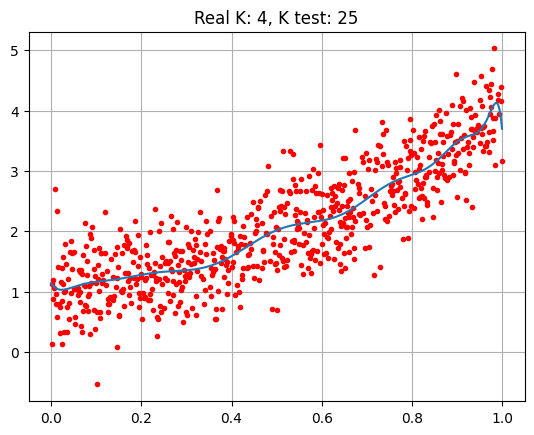

The best tradeoff is given by K = 2


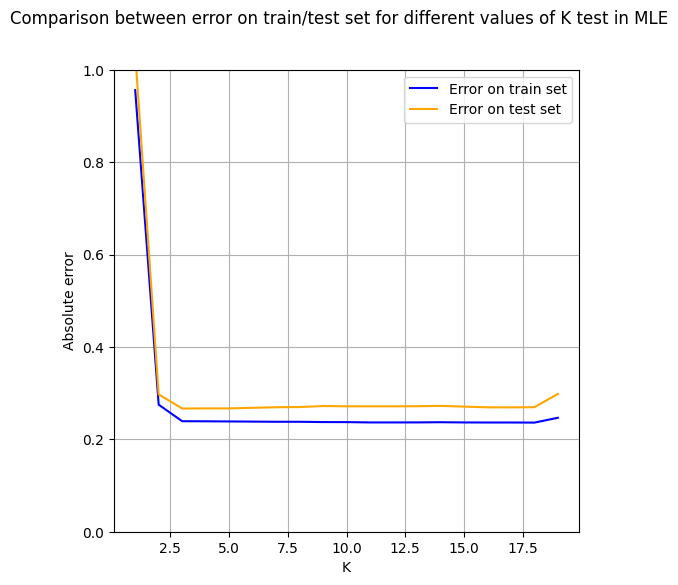

In [237]:
K_test = 25

theta_mle = mle(D2, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D2,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T2,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true2))
plt.title("Real K: "+str(K2)+", K test: "+str(K_test))
plot_approximation(D2, K_test, theta_mle)

train_errors = []
test_errors = []
maxk = 20
for k in range(1, maxk):
    theta_mle = mle(D2, k, type="normal")
    train_errors.append(abs_error(D2,k,theta_mle))
    test_errors.append(abs_error(T2,k,theta_mle))

dif = abs(np.array(train_errors) - np.array(test_errors))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)

x_plot = np.arange(1,maxk)
plt.figure(figsize=(6,6))
plt.suptitle("Comparison between error on train/test set for different values of K test in MLE")
plt.plot(x_plot, train_errors, color="blue")
plt.plot(x_plot, test_errors, color="orange")
plt.legend(["Error on train set","Error on test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.ylim(0,1)
plt.grid()
plt.show()

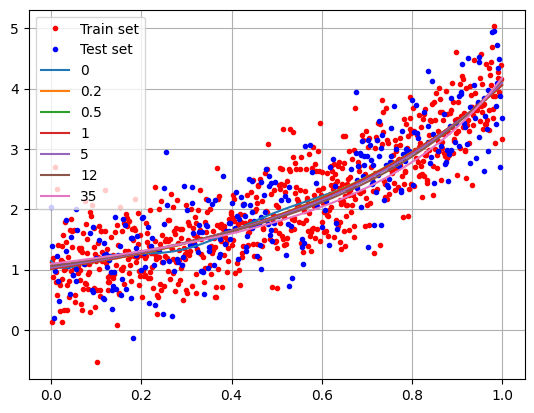

The best tradeoff is given by K = 2


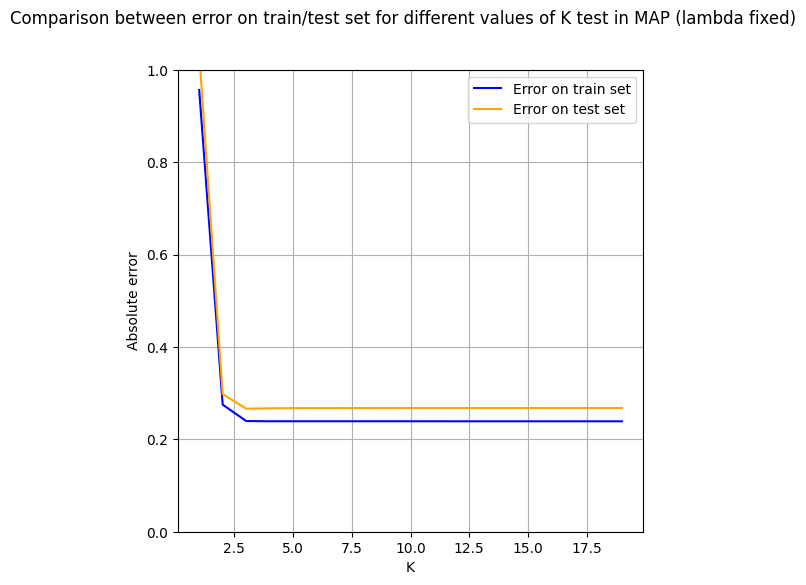

In [238]:
K_test = 10
theta_map = map(D2, K_test, type="normal")
plot_approximation(D2, K_test, theta_map, all=True, T=T2, lam=lam_values)

train_errors = []
test_errors = []
maxk = 20
for k in range(1, maxk):
    theta_map = map(D2, k, type="normal")
    train_errors.append(abs_error(D2,k,theta_map))
    test_errors.append(abs_error(T2,k,theta_map))

dif = abs(np.array(train_errors) - np.array(test_errors))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)

x_plot = np.arange(1,maxk)
plt.figure(figsize=(6,6))
plt.suptitle("Comparison between error on train/test set for different values of K test in MAP (lambda fixed)")
plt.plot(x_plot, train_errors, color="blue")
plt.plot(x_plot, test_errors, color="orange")
plt.legend(["Error on train set","Error on test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.ylim(0,1)
plt.grid()
plt.show()